In [1]:
%matplotlib notebook

import os
import glob
import copy
import requests
import json

import numpy as np

import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
from astropy.time import Time
from astropy.table import Table, vstack
from astropy.stats import SigmaClip
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D

from astroquery.imcce import Skybot

import matplotlib.pyplot as plt

from plot_utils import (iter_over_obj, plot_all_objs, 
                        plot_focal_plane, plot_cutouts, plot_img, 
                        plot_footprint, plot_footprints, plot_bbox, plot_bboxes)

# Objects crossing COSMOS 1 field of DDF in 2021

## DDF and COSMOS 1 Field

The Deep Drilling Field (DDF) is an optical imaging survey conducted with the Dark Energy Camera (DECam) on the 4-m Blanco telescope at the Cerro Tololo Inter-American Observatory (CTIO) repeatedly images several fields (refered to as COSMOS 1, 2 and 3 and DECals). The part of survey considered here covers the target named "COSMOS 1" over ~40 epochs (nights) per field and 5 to 6 images per night per filter in g, r, i, and/or z. The subset covers the timespan from 2021-03-19 to 2022-01-24 (21A and 21B halves). 

The survey is described in more depth in [this paper](https://ui.adsabs.harvard.edu/abs/2023MNRAS.519.3881G/abstract). 

The COSMOS 1 field is generally located at:

In [2]:
ra_center = 150.002625
dec_center = 3.09713889
radius = 1.15 # degrees

To follow along this notebook download an example of the primary pointing:

In [3]:
# To get the primary pointing uncomment and execute cell
#!wget https://astroarchive.noirlab.edu/api/retrieve/c1db52de6dad0d8a4068fdd4a8e35e1c/

We mainly need this to build the bounding boxes of a single exposure to contextualize the tracks across the field.

The exposure filters and dates in the COSMOS 1 field can be retrieved from Astro Data Archive advanced search API:

## Objects transiting the FOV in 2021

In this section we'll take a peek at some of the properties of known objects that were returned in the previous section. If you're relying on the data provided in the repository, this is where you should start.

The following code assumed you have access to at least 1 example field in order to properly draw bounding boxes and that the `known_objects_in_cosmos_1.ecsv` exists as in format expected.

In [4]:
img = fits.open("c4d_210319_003604_ooi_g_v1.fits")
objects = Table.read("known_objects_in_cosmos_1_calibrated_exps.ecsv")

In [5]:
# lol, wtf is wrong with the original dataset if 
# the number of unique magnitudes is only 106 - 
# there should be ~2k objects, and ~20k ephemerids
unique_mags = list(set(objects["V"]))
unique_mags.sort()


# I want to use objects max mag to create a list
# of the objects sorted (descending) on mags.
# But same object could appear multiple times because
# it grows brighter and dimmer (potentially) so we 
# create a list of observations based on magnitudes
# then de-duplicate while preserving order. This
# should result in a list of object names, sorted
# in descending order of magnitudes based on their
# brightest mag observation.
brightest_to_dimmest = []
for um in unique_mags:
    objs = objects[objects["V"] == um]["Name"]
    brightest_to_dimmest.extend(objs)

lookup = set()
brightest_to_dimmest = [obj for obj in brightest_to_dimmest if obj not in lookup and lookup.add(obj) is None]

<IPython.core.display.Javascript object>


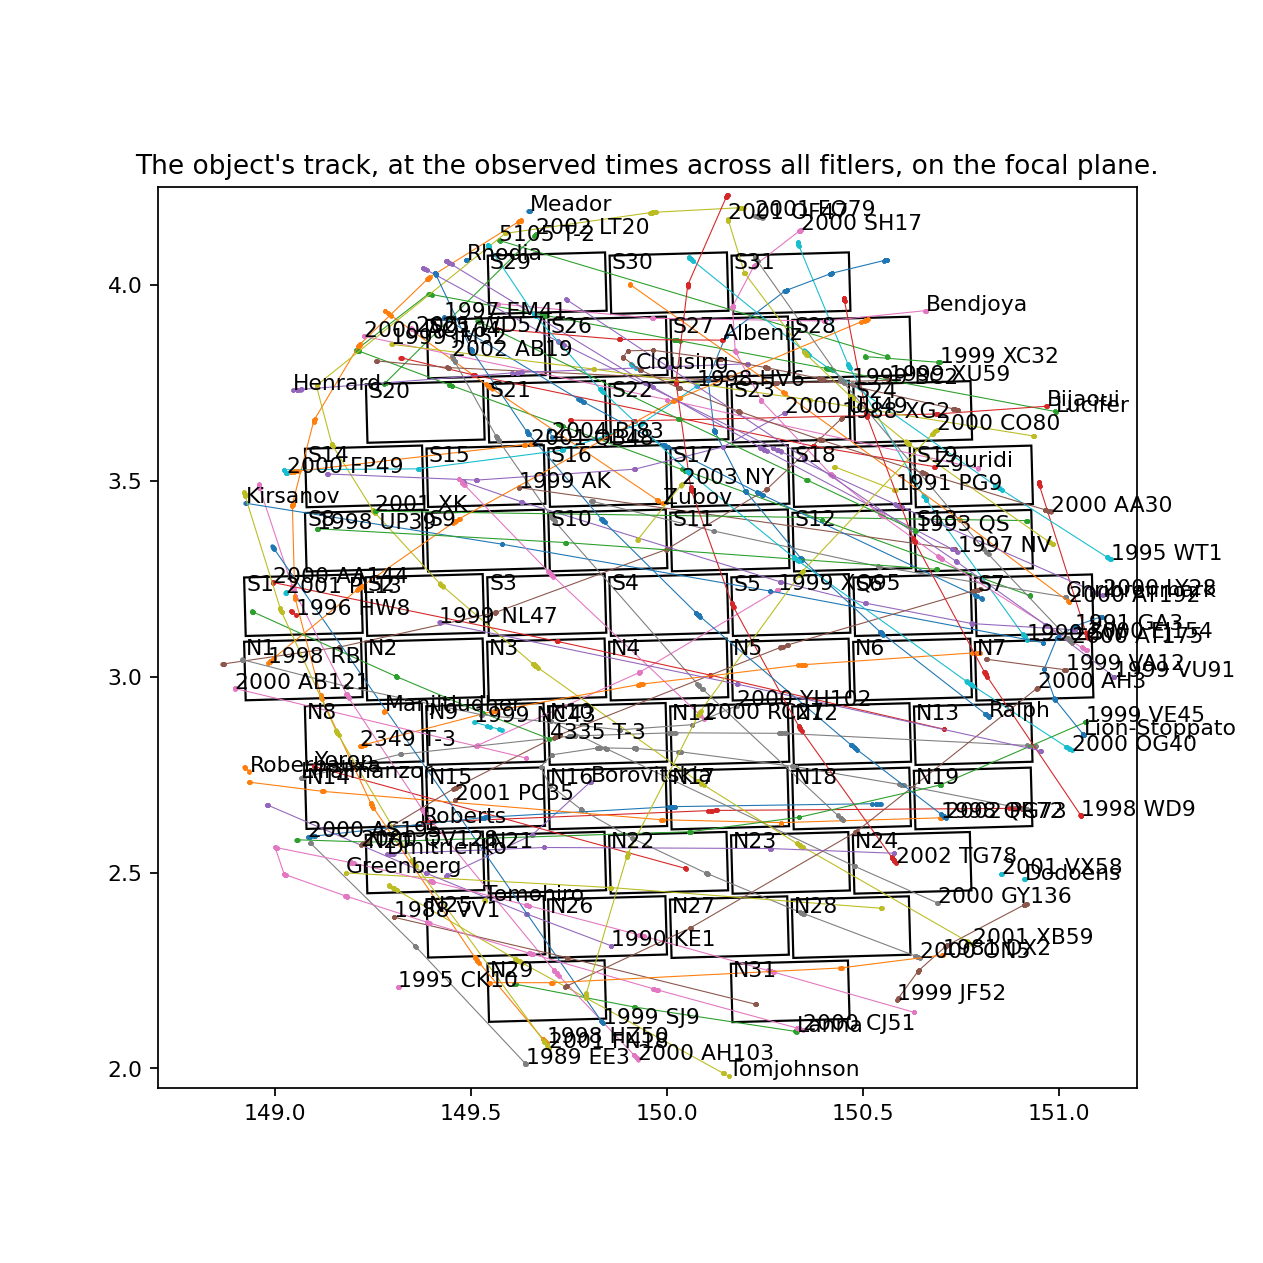

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))

nobjs = 100

plot_focal_plane(ax, img)
i = 0
for objname in brightest_to_dimmest:
    obj = objects[objects["Name"] == objname] 
    ax.plot(obj["RA"], obj["DEC"], label=obj["Name"][0], marker="o", lw=0.5, ms=1)
    ax.text(obj["RA"][0], obj["DEC"][0], obj["Name"][0])
    i += 1
    if i >= nobjs:
        break
    
    
ax.set_title("The object's track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(1.95, 4.25)
ax.set_aspect("equal")
#fig.legend()

The object could have been observed a total of 124 times in any filter.


<IPython.core.display.Javascript object>


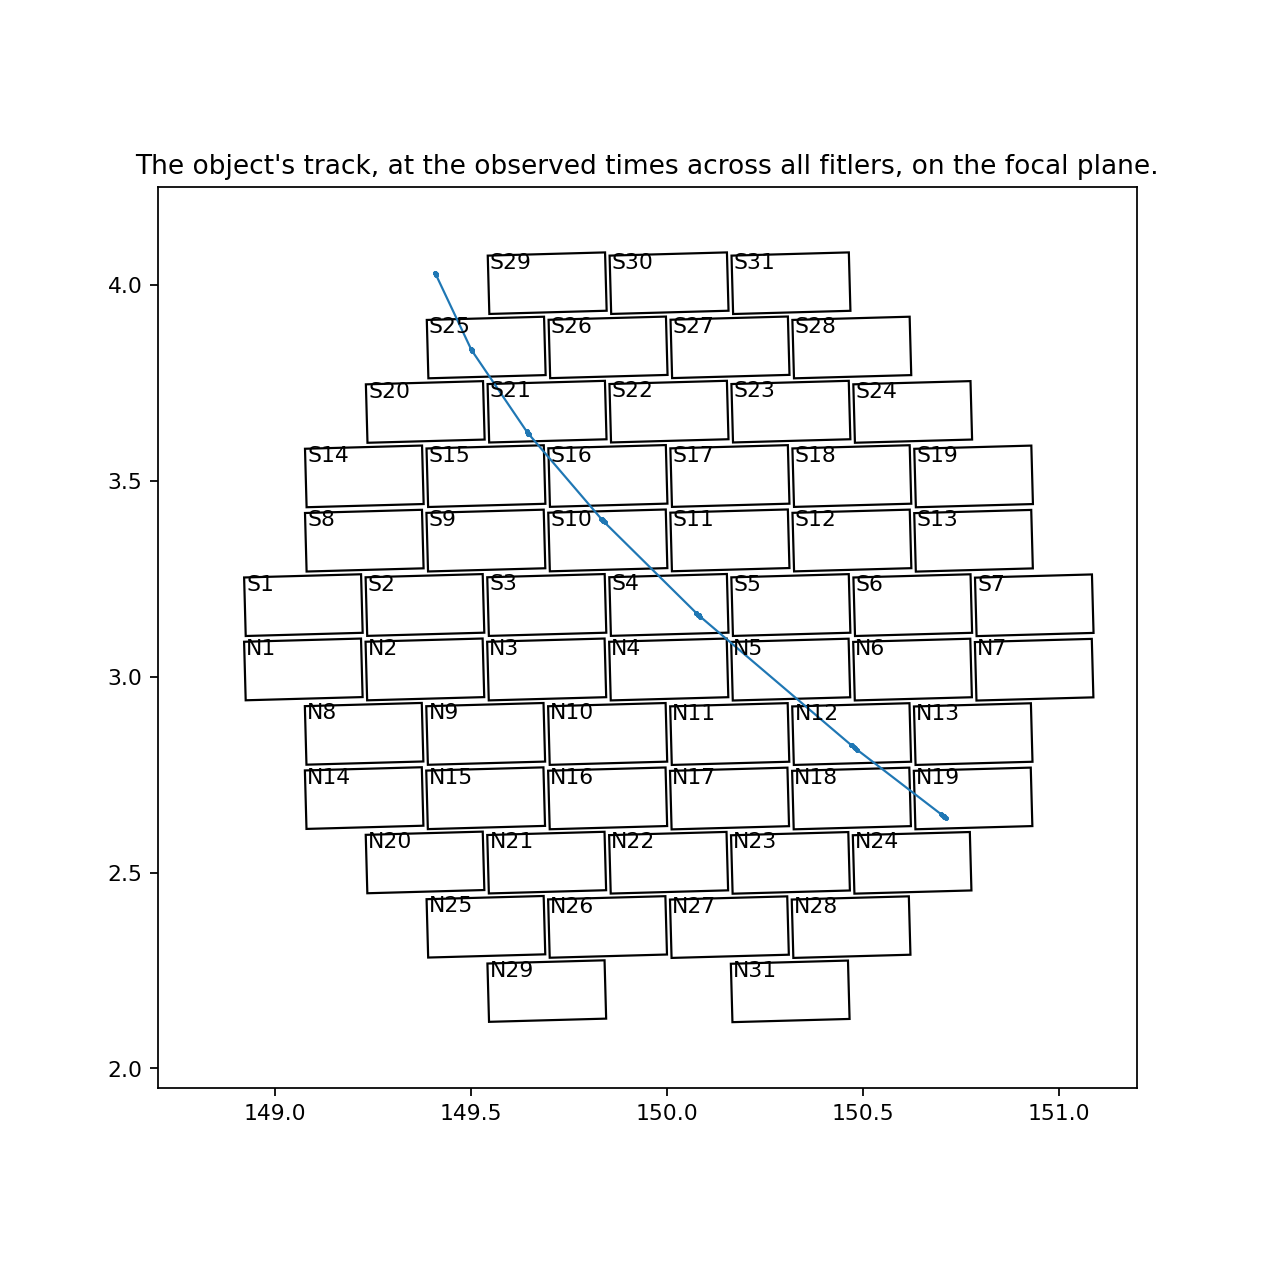

In [7]:
obj_only = objects[objects["Name"] == "2002 PG73"]
print(f"The object could have been observed a total of {len(obj_only)} times in any filter.")

fig, ax = plt.subplots(figsize=(8, 8))

plot_focal_plane(ax, img)
plot_all_objs(ax, obj_only, (ra_center, dec_center), show_field=False, lw=1, ms=1.1)

ax.set_title("The object's track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(1.95, 4.25)
ax.set_aspect("equal")

In [9]:
root = "2002_PG73"

def extract_metadata(root, force=False, default_exported_table="2002_PG73_extracted_fits_metadata.ecsv"):
    # Ah, screw it, I have to unravel everything in a table because 
    # I can't find even a very bright object in these images and I'm not sure what's 
    # going on
    images = Table(names=["fname", "detpos", "ccdnum", "obstime", "filter", "band", "bbox", "wcs"], 
                   dtype=[str,          str,      int,    object,      str,    str, object, object])

    if not force and os.path.exists(default_exported_table):
        images = Table.read(default_exported_table)
        
        # wcss = [WCS(wcs) for wcs in images["wcs"]]
        # I would have done it like that, but because 
        # of issues/4669 we need to monkeypatch the
        # image dimensions back into the WCS
        wcss = []
        for wcs in images["wcs"]:
            tmpwcs = WCS(wcs)
            tmpwcs._naxis = [2046, 4094]
            wcss.append(tmpwcs)

        images["wcs"] = wcss
        times = [Time(t) for t in images["obstime"]]
        images["obstime"] = times
        return images
    
    wcss, times = [], []
    for fp in glob.glob(f"{root}/*/*fits.fz"):
        hdul = fits.open(fp)
        fname = fp.split(os.sep)[-1]
        obstime = hdul["PRIMARY"].header["DATE-OBS"]
        band = hdul["PRIMARY"].header["FILTER"]
        for hdu in hdul:
            wcs = WCS(hdu.header)
            bbox = wcs.calc_footprint()
            if bbox is not None:
                wcss.append(wcs)
                times.append(Time(obstime))
                images.add_row([
                    fname,
                    hdu.header["DETPOS"],
                    hdu.header["CCDNUM"],
                    obstime,
                    band[0],
                    band,
                    bbox,
                    wcs.to_header_string()
                ])
                
    images.meta["comment"] = ("DDF COSMOS 1 field FITS files made in 2021 are downloaded at the "
                              "time-stamps of when object 202_PG73 was transiting the field; had "
                              "their metadata extracted and placed in an Astropy Table object. "
                              f"Created {Time.now()}")
    images.write()
    images["wcs"] = wcss
    images["obstime"] = times
                
    return images

images = extract_metadata(root)

times = [Time(t) for t in obj_only["obstime"]]
obj_only["obstime"] = times

In [12]:
images

fname,detpos,ccdnum,obstime,filter,band,bbox,wcs
str34,str3,int64,Time,str1,str32,object,object
c4d_210328_013735_ooi_r_v1.fits.fz,S29,1,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.54214164 4.07470407]\n [149.84177329 4.07475152]\n [149.84159163 3.92579093]\n [149.5419483 3.92559547]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 13422.2 6306.333 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
c4d_210328_013735_ooi_r_v1.fits.fz,S30,2,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.85323676 4.07467313]\n [150.152954 4.07390044]\n [150.15262079 3.92495397]\n [149.85278575 3.92571737]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 13422.2 2047.0 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
c4d_210328_013735_ooi_r_v1.fits.fz,S31,3,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[150.16455567 4.07457188]\n [150.46419298 4.07400778]\n [150.46411751 3.92490756]\n [150.16446723 3.92561812]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 13422.2 -2212.333 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
c4d_210328_013735_ooi_r_v1.fits.fz,S25,4,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.38648769 3.91055341]\n [149.68597673 3.91081969]\n [149.68569397 3.76174931]\n [149.38622124 3.76141523]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 11167.8 8436.0 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
c4d_210328_013735_ooi_r_v1.fits.fz,S26,5,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[149.69746367 3.91088041]\n [149.99725609 3.91099657]\n [149.9971797 3.7619361 ]\n [149.69725535 3.76182338]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 11167.8 4176.667 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
c4d_210328_013735_ooi_r_v1.fits.fz,S27,6,2021-03-28T01:37:35.409,r,r DECam SDSS c0002 6415.0 1480.0,[[150.00881585 3.91095322]\n [150.30861342 3.91037141]\n [150.30856112 3.76130624]\n [150.00863307 3.7618964 ]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0022571638 3.095990028206 \nCRPIX : 11167.8 -82.66665 \nPC1_1 PC1_2 : -7.192336928623e-08 7.28553171497e-05 \nPC2_1 PC2_2 : -7.285727154354e-05 -6.141009930499e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
...,...,...,...,...,...,...,...
c4d_210406_004510_ooi_g_v1.fits.fz,N24,55,2021-04-06T00:45:10.980,g,g DECam SDSS c0001 4720.0 1520.0,[[150.47640628 2.59425133]\n [150.77531509 2.59438369]\n [150.77490553 2.44513461]\n [150.47600838 2.44501151]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0043438937 3.095754365348 \nCRPIX : -6867.4 -6471.667 \nPC1_1 PC1_2 : -6.09121527839e-08 7.285222484373e-05 \nPC2_1 PC2_2 : -7.285565652553e-05 -5.292185839671e-08 \nCDELT : 1.0 1.0 \nNAXIS : 2046 4094
c4d_210406_004510_ooi_g_v1.fits.fz,N25,56,2021-04-06T00:45:10.980,g,g DECam SDSS c0001 4720.0 1520.0,[[149.38801001 2.43099002]\n [149.68711738 2.43040921]\n [149.68720652 2.28134925]\n [149.38815818 2.28184008]],WCS Keywords\n\nNumber of WCS axes: 2\nCTYPE : 'RA---TAN' 'DEC--TAN' \nCRVAL : 150.0043438937 3.095754365348 \nCRPIX : -9121.8 8436.0 \nPC1_1 PC1_2 : -6.09121527839e-08 7.285222484373e-05 \nP

In [16]:
cutoutsize = 100

cutouts = Table(
    names=["obs_num", "fname", "detpos", "filter", "cutout"],
    dtype=[     int,     str,      str,      str,   object]
)


for i, observation in enumerate(obj_only):
    timestamp_mask = (abs(images["obstime"] - observation["obstime"])) <= 15*u.s
    
    ephem = SkyCoord(observation["RA"]*u.deg, observation["DEC"]*u.deg)
    for j, hdu in enumerate(images[timestamp_mask]):
        if hdu["wcs"].footprint_contains(ephem):
            tmpfits = fits.open(f"{root}/{hdu['filter']}/{hdu['fname']}")
            cutouts.add_row([
                observation["Number"],
                hdu["fname"],
                hdu["detpos"],
                hdu["filter"],
                Cutout2D(tmpfits[hdu["detpos"]].data, ephem, cutoutsize, wcs=hdu["wcs"])
            ])    
            

In [17]:
cutouts

obs_num,fname,detpos,filter,cutout
int64,str34,str3,str1,object
78316,c4d_210322_013848_ooi_g_v1.fits.fz,N19,g,<astropy.nddata.utils.Cutout2D object at 0x7f4695e2a740>
78316,c4d_210324_012243_ooi_g_v1.fits.fz,N12,g,<astropy.nddata.utils.Cutout2D object at 0x7f4695fb9960>
78316,c4d_210328_013530_ooi_g_v1.fits.fz,S4,g,<astropy.nddata.utils.Cutout2D object at 0x7f469604c4c0>
78316,c4d_210328_013932_ooi_i_v1.fits.fz,S4,i,<astropy.nddata.utils.Cutout2D object at 0x7f4695ddc760>
78316,c4d_210328_030611_ooi_r_v1.fits.fz,S4,r,<astropy.nddata.utils.Cutout2D object at 0x7f469565c7c0>
78316,c4d_210328_032516_ooi_r_v1.fits.fz,S4,r,<astropy.nddata.utils.Cutout2D object at 0x7f4696a4c370>
78316,c4d_210328_032713_ooi_i_v1.fits.fz,S4,i,<astropy.nddata.utils.Cutout2D object at 0x7f469604dd50>
78316,c4d_210328_032812_ooi_i_v1.fits.fz,S4,i,<astropy.nddata.utils.Cutout2D object at 0x7f469604d990>
78316,c4d_210331_020552_ooi_g_v1.fits.fz,S10,g,<astropy.nddata.utils.Cutout2D object at 0x7f46968862f0>


In [18]:
row_hdu_map = {}
cutoutsize = 100
cutouts = []
for i, row in enumerate(obj):
    img = imgs[row["fname"]]
    ephem = SkyCoord(row["RA"]*u.deg, row["DEC"]*u.deg)
    
    for (j, wcs), t in zip(wcss, times):
        if wcs.footprint_contains(ephem) and (t-Time(row["obstime"])) < 0.1*u.hr:
            hdu = img[j]
            row_hdu_map[i] = hdu
            cutouts.append(Cutout2D(hdu.data, ephem, cutoutsize, wcs=wcs))

<IPython.core.display.Javascript object>


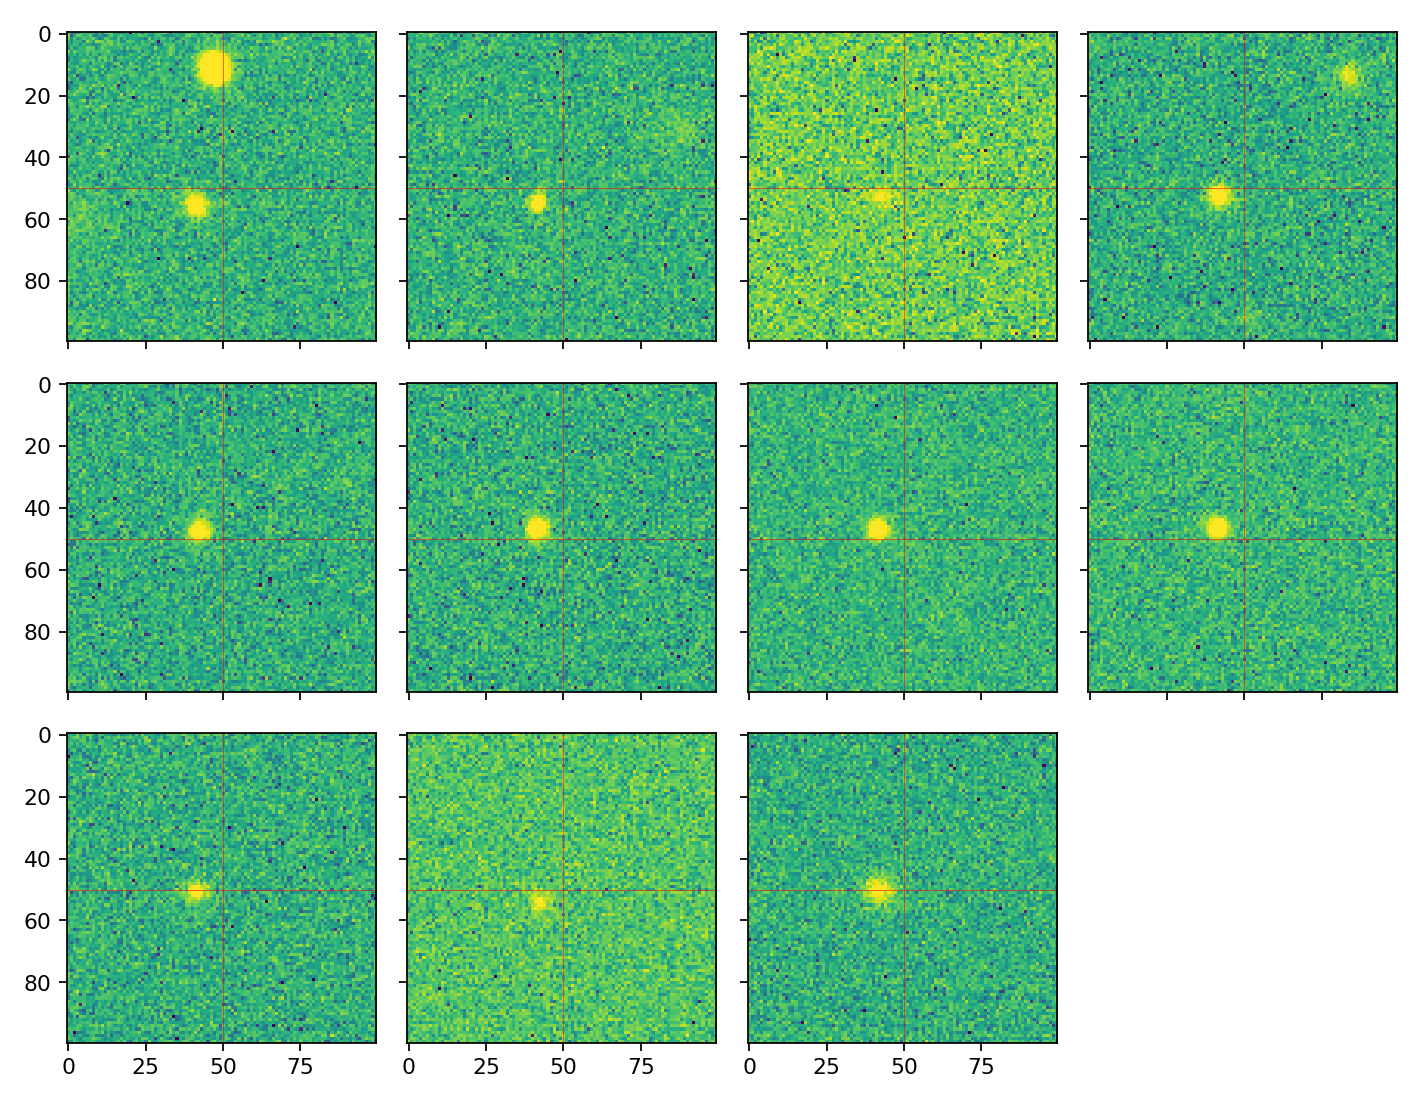

In [29]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(9, 7), sharex=True, sharey=True)
plot_cutouts(axes, cutouts["cutout"])
fig.tight_layout()